In [1]:
%cd ~/dev-personal/IMA/ImpRA

/home/nahue/dev-personal/IMA/ImpRA


/home/nahue/dev-personal/IMA/ImpRA/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [2]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

from impra import utils
from impra.process.smoothing import Smoothers
from impra.process.filtering import Filters
from impra.process.parameters import ParametersCalculationWrapper

### Test 1

In [5]:
cfg = {
    "sample_rate": 48000,
    "filtering": {
        "type": Filters.OCTAVE_BAND,
        "flip_ir": True,
    },
    "smoothing": {
        "type": Smoothers.SCHROEDER_INVERSE_INTEGRAL,
        "args": {},
    },
}

In [6]:
audio_path = Path("audio_tests/rirs/impulse_response_1.wav")

filtering_cfg = cfg["filtering"]
smoothing_cfg = cfg["smoothing"]
sample_rate = 48000

### 
signal_array, sample_rate = utils.load_signal(audio_path, sample_rate)

if filtering_cfg["flip_ir"]:
    signal_array = utils.flip_signal(signal_array)

# Filtering
filter = filtering_cfg["type"].value()
signal_filtered = filter.filter(signal_array)

if filtering_cfg["flip_ir"]:
    signal_filtered = utils.flip_signal(signal_filtered)

# Hilbert envelope
hilbert_envelope = Smoothers.HILBERT_ENERGY_ENVELOPE.value()
energy_envelope = hilbert_envelope.smooth(signal_filtered, sample_rate)

# Smoothing
smoother = smoothing_cfg["type"].value(**smoothing_cfg["args"])
energy_smoothed = []
for band_i in energy_envelope:
    energy_smoothed.append(smoother.smooth(band_i, sample_rate))
energy_smoothed = np.array(energy_smoothed)

# Linear to dB
energy_smoothed_db = utils.to_db_normalized(energy_smoothed)

/home/nahue/dev-personal/IMA/ImpRA/impra/utils/utils.py:70: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(signal_array / max_values)


In [7]:
def ttyedtt(x, y, fs):
    '''
    Calculate Tt and early decay time (EDT) from a filtered IR.
    Parameters
    ----------
    x : array
        Array containing the filtered IR per frequency band in each row.
    y : array
        Array containing the .
    fs : int
        Sampling frequency.
    Returns
    -------
    Tt : float
        Transition time.
    EDTt : float
        Early decay time.
    '''
    
    EDTt = []
    Tt = []
    
    for i, ir in enumerate(x):
        
        # Remove the first 5 ms
        
        ir = ir[int(5e-3 * fs):]  
        
        # Find the index of the upper limit of the interval that contains 
        # 99% of the energy 
        
        index = np.where(np.cumsum(ir ** 2) <= 0.99 * np.sum(ir ** 2))[0][-1]
        t_t = index/fs
        Tt.append(t_t)
                
        # Filter the impulse with the moving median filter in order to calculate
        # the parameters
        
        ir2 = y[i]
        ir2 = ir2[:index]  
        t_Tt = np.arange(0, index/fs, 1/fs)
        
        if len(t_Tt) > index:
            t_Tt = t_Tt[:index]
        
        # Calculate minimum squares
            
        A = np.vstack([t_Tt, np.ones(len(t_Tt))]).T
        m, c = np.linalg.lstsq(A, ir2, rcond=-1)[0]
        
        edt_t = -60/m
        EDTt.append(edt_t)
        
    EDTt = np.round(EDTt, 2)
    Tt = np.round(Tt, 2)
    
    return Tt, EDTt

In [8]:
ttyedtt(energy_envelope, energy_smoothed_db, sample_rate)

(array([1.49, 1.49, 0.18, 0.18, 0.21, 0.25, 0.22, 0.23, 0.16, 0.15]),
 array([21.51,   nan,   nan,   nan,   nan,   nan,  1.42,  1.48,  2.04,
         1.88]))

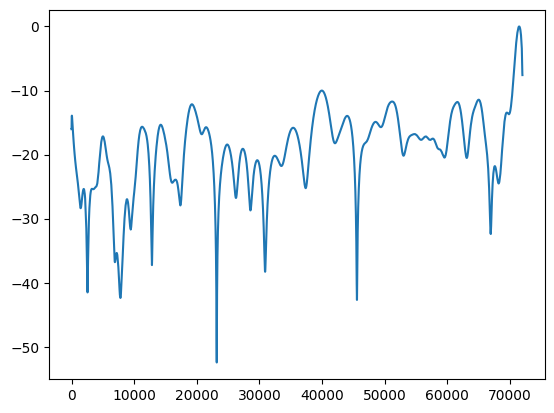

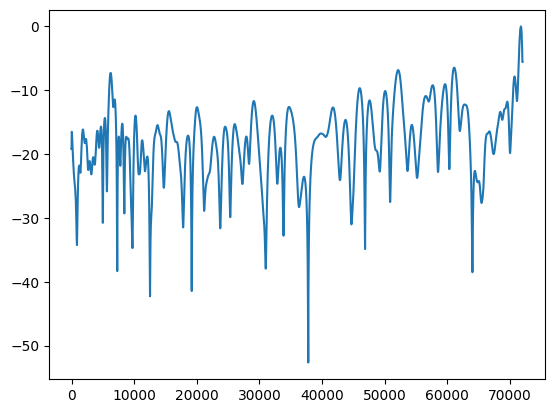

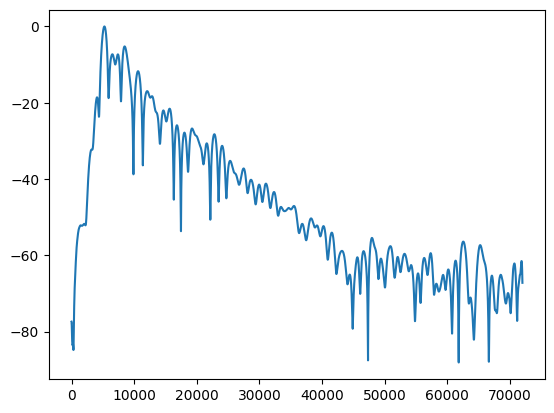

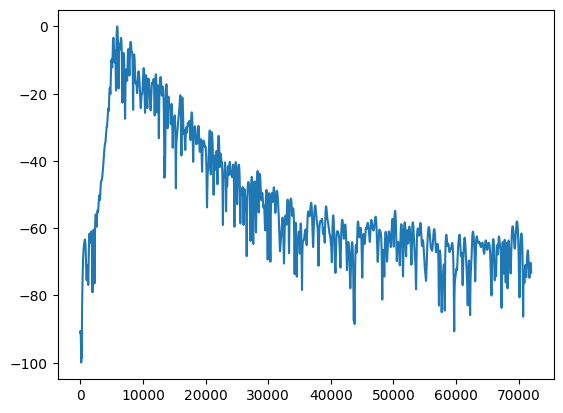

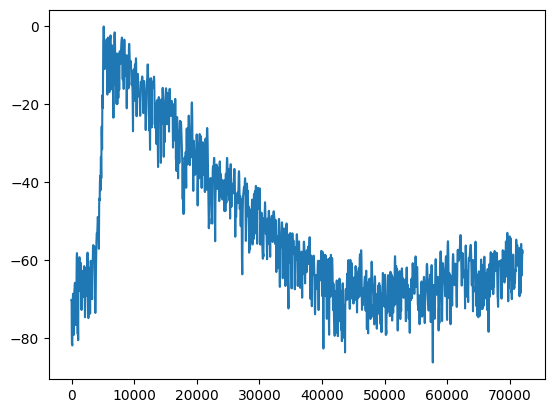

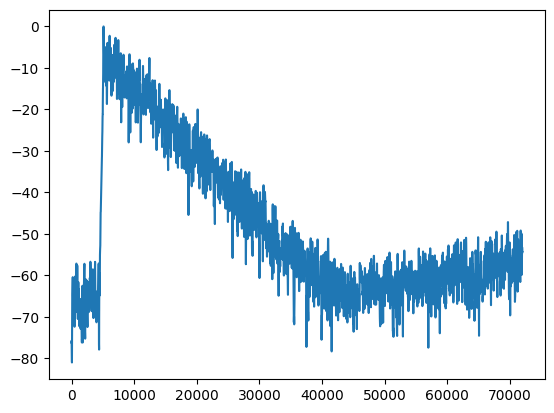

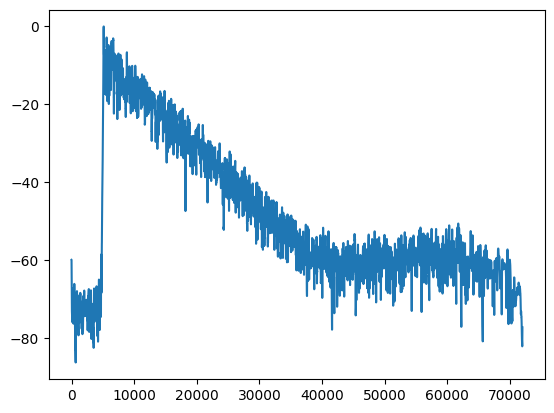

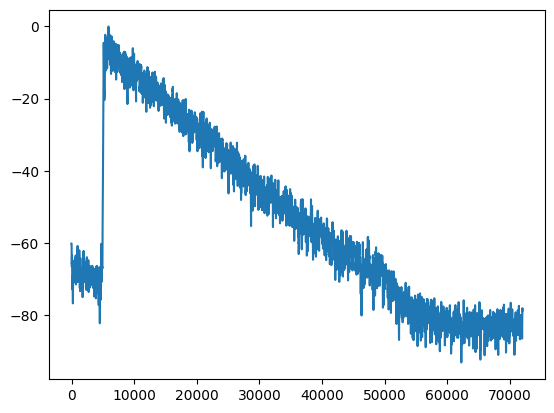

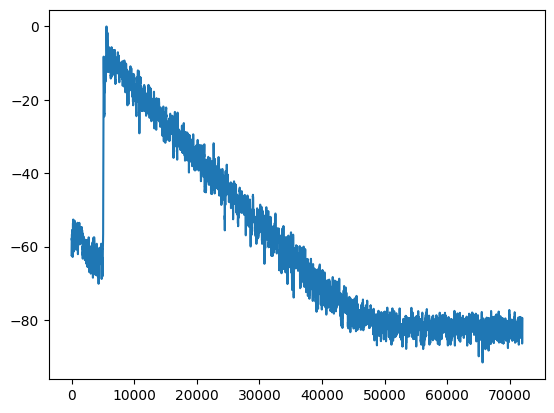

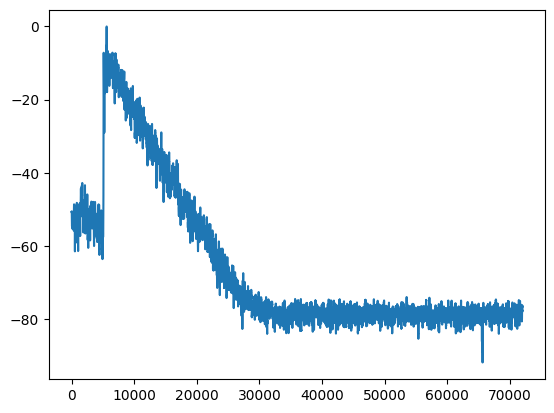

In [10]:
for i in energy_smoothed_db:
    plt.plot(i)
    plt.show()

### Test 2

In [7]:
from impra.engine.core import ImpulseResponseAnalyzer

cfg = {
    "sample_rate": 48000,
    "filtering": {
        "type": Filters.THIRD_OCTAVE_BAND,
        "flip_ir": True,
    },
    "smoothing": {
        "type": Smoothers.SCHROEDER_INVERSE_INTEGRAL,
        "args": {},
    },
}

analyzer = ImpulseResponseAnalyzer(cfg)

In [8]:
audio_path = Path("tests/impulse_responses/impulse_response_1.wav")

analyzer.analyze(audio_path)

/home/nahue/dev-personal/IMA/ImpRA/impra/utils/utils.py:70: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(signal_array / max_values)


,31.5 Hz,40 Hz,50 Hz,63 Hz,80 Hz,100 Hz,125 Hz,160 Hz,200 Hz,250 Hz,...,2 kHz,2 kHz,3 kHz,4 kHz,5 kHz,6 kHz,8 kHz,10 kHz,12 kHz,16 kHz
EDT,0.54,0.43,0.58,0.75,9.04,0.09,0.01,0.77,0.45,0.00,...,0.17,0.85,0.89,0.85,0.79,0.72,0.65,0.51,0.40,0.32
T20,0.09,0.07,0.06,0.05,0.05,0.01,0.05,0.75,0.66,0.00,...,0.06,0.81,0.79,0.80,0.81,0.73,0.63,0.50,0.39,1.32
T30,0.08,0.07,0.06,0.05,0.05,0.01,0.05,0.78,0.65,0.02,...,0.06,0.81,0.78,0.80,0.80,0.73,0.63,0.50,0.40,5.35
C50,-17.92,-17.72,-17.55,-17.30,-17.88,-33.21,-35.34,-28.84,-36.64,-38.58,...,-65.30,-67.53,-67.92,-64.51,-60.49,-56.67,-52.73,-49.92,-42.38,-29.77
C80,-17.85,-17.67,-17.52,-17.27,-17.80,-15.44,-18.43,-19.34,-26.29,-25.80,...,-63.30,-65.57,-66.60,-62.40,-59.17,-55.71,-51.77,-48.96,-40.87,-27.88
Tt,1.49,1.49,1.49,1.49,1.49,0.22,0.19,0.18,0.17,0.24,...,0.19,0.23,0.23,0.25,0.23,0.20,0.18,0.16,0.15,0.14
EDTt,68.54,88.17,73.82,80.14,47.62,NaN,NaN,1.30,1.67,NaN,...,NaN,1.41,1.47,1.41,1.45,1.51,1.46,1.61,1.84,2.03
